# Receptive fields

We will obtain the receptive fields of any given model by building deltas as inputs to calculate the differential response of the model.

## Importing libraries

In [2]:
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from perceptualtests.receptive_fields import *

## Define a `tf.data.Dataset` from the deltas generator

> We will create a only-background image to calculate the differences at each step.

In [3]:
img_height, img_width, channels, fov = 384, 512, 3, 32

In [9]:
bg_gain = 0.5
delta_gain = 0.05
background = np.zeros(shape=(img_height,img_width,channels)) + bg_gain
deltas_dataset = tf.data.Dataset.from_generator(obtain_receptive_field_gen, 
                                                args=(img_height,img_width,channels,fov, bg_gain, delta_gain),
                                                output_signature=(
                                                    tf.TensorSpec(shape=(img_height,img_width,channels), dtype=tf.float32)
                                                    )
                                                )

## Passing the deltas through the network

As an example we'll use a fake model that we can override at any time:

In [11]:
class FakeNetwork():
    def __call__(self, X):
        return X
    def predict(self, X):
        return self(X)

In [12]:
model = FakeNetwork()

### Keeping only one channel

In [6]:
%%time
channel_to_keep = 0
batch_size = 10

responses = np.empty(shape=(fov*2)*(fov*2)*channels)
for i, delta in tqdm(enumerate(deltas_dataset.batch(batch_size)), total=fov*2*fov*2*channels//batch_size):
    response = model.predict(delta)
    ## Now we keep only the center response of a specific channel
    response_height, response_width = response.shape[1:3] # [BatchDim, H, W, C]
    responses[i*batch_size:i*batch_size+batch_size] = response[:,response_height//2,response_width//2,channel_to_keep]

2022-05-04 08:13:37.521913: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  0%|          | 0/1228 [00:00<?, ?it/s]

CPU times: user 45.9 s, sys: 2.79 s, total: 48.7 s
Wall time: 47.4 s


In [7]:
responses2 = responses.reshape((fov*2, fov*2, channels))
# rf = (responses2 - responses2.min()) / (responses2.max() - responses2.min())
rf = normalization_fixed_0(responses2, expo=0.5)
rf.shape

(64, 64, 3)

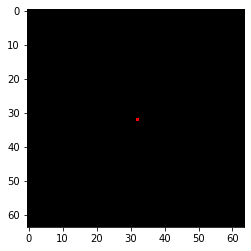

In [8]:
plt.imshow(rf)
plt.show()

### Keeping all the channels

In [13]:
%%time
batch_size = 16
output_channels = 3

## We will calculate the response to the background first
response_bg = model.predict(background[None,:,:,:])

responses = np.empty(shape=((fov*2)*(fov*2)*channels, output_channels))
for i, delta in tqdm(enumerate(deltas_dataset.batch(batch_size)), total=fov*2*fov*2*channels//batch_size):
    response = model.predict(delta) - response_bg
    ## Now we keep only the center response of a specific channel
    response_height, response_width = response.shape[1:3] # [BatchDim, H, W, C]
    responses[i*batch_size:i*batch_size+batch_size] = response[:,response_height//2,response_width//2,:]

2022-05-08 18:32:51.267238: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  0%|          | 0/768 [00:00<?, ?it/s]

CPU times: user 48.8 s, sys: 18.9 s, total: 1min 7s
Wall time: 1min 6s


In [21]:
responses = normalization_fixed_0(responses, expo=0.5)
responses.shape

(12288, 3)

In [22]:
responses.shape, response.shape

((12288, 3), TensorShape([16, 384, 512, 3]))

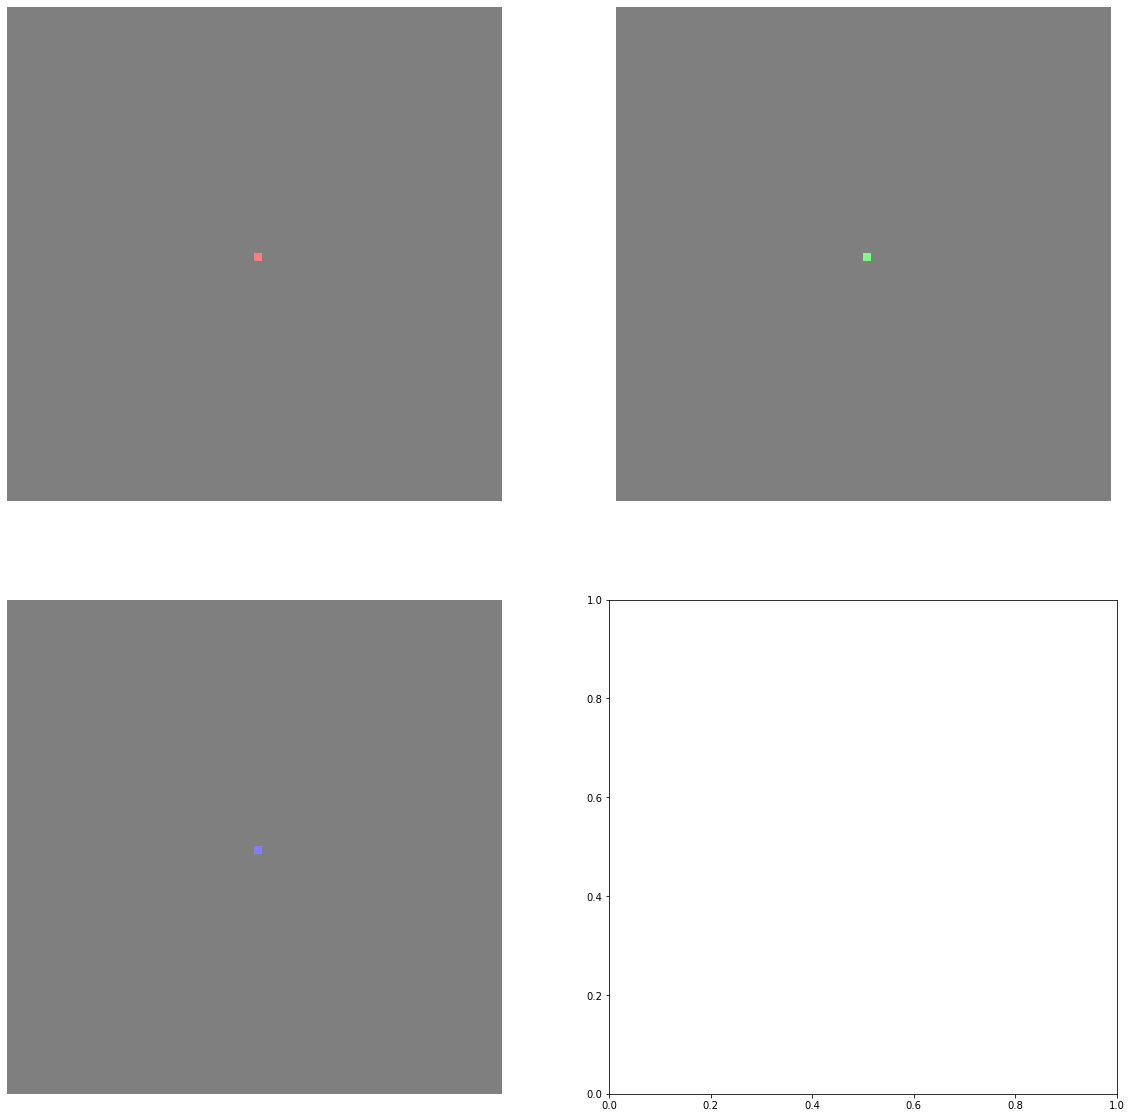

In [23]:
nrows, ncols = [int(np.ceil(np.sqrt(output_channels)))]*2
fig, ax = plt.subplots(nrows, ncols, figsize=(20,20))
ax = ax.ravel()
for ch in range(output_channels):
    ch_response = responses[:,ch]
    ch_response = ch_response.reshape((fov*2, fov*2, channels))
    ax[ch].imshow(ch_response)
    ax[ch].axis('off')
    # break
plt.show()